In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# SEIS Model

### Euler's method: Solution to deterministic model, i.e. numerical solution to differential eq.

In [2]:
# --- Denmark COVID-19 scenario -------------------------------
beta    = 0.1519137        # from dataset
gamma   = 0.01537969       # from dataset
epsilon = 1/5.1            # 1 / 5.1-day incubation

S0 = 5_826_529             # susceptibles
E0 = 1_000                 # exposed
I0 = 500                   # infectious
days = 200                 # simulate ~ 5 months

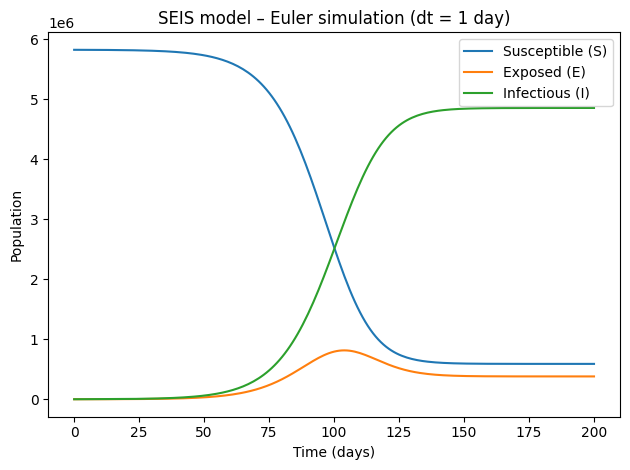

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def simulate_seis(beta: float,
                  gamma: float,
                  epsilon: float,
                  S0: float,
                  E0: float,
                  I0: float,
                  days: int,
                  dt: float = 1.0):
    """
    Euler-method simulation of the SEIS epidemic model.

    Parameters
    ----------
    beta      : transmission rate
    gamma     : recovery rate
    epsilon   : incubation infectious rate
    S0, E0, I0: initial population counts
    days      : number of days to simulate
    dt        : time step (default = 1 day)

    Returns
    -------
    t : ndarray, simulation time points
    S : ndarray, susceptibles over time
    E : ndarray, exposed over time
    I : ndarray, infectious over time
    """
    steps = int(days / dt)
    t = np.arange(steps + 1) * dt

    S = np.empty(steps + 1, dtype=float)
    E = np.empty(steps + 1, dtype=float)
    I = np.empty(steps + 1, dtype=float)

    # initial conditions
    S[0], E[0], I[0] = S0, E0, I0
    N = S0 + E0 + I0   # total population (assumed constant)

    # Euler forward integration
    for k in range(steps):
        dS = (-beta * S[k] * I[k] / N) + gamma * I[k]
        dE =  (beta * S[k] * I[k] / N) - epsilon * E[k]
        dI =  (epsilon * E[k]) - gamma * I[k]

        S[k + 1] = S[k] + dS * dt
        E[k + 1] = E[k] + dE * dt
        I[k + 1] = I[k] + dI * dt

    return t, S, E, I



t, S, E, I = simulate_seis(beta, gamma, epsilon, S0, E0, I0, days)

# Plot results
plt.figure()
plt.plot(t, S, label="Susceptible (S)")
plt.plot(t, E, label="Exposed (E)")
plt.plot(t, I, label="Infectious (I)")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("SEIS model – Euler simulation (dt = 1 day)")
plt.legend()
plt.tight_layout()
plt.show()


### Play with constants:

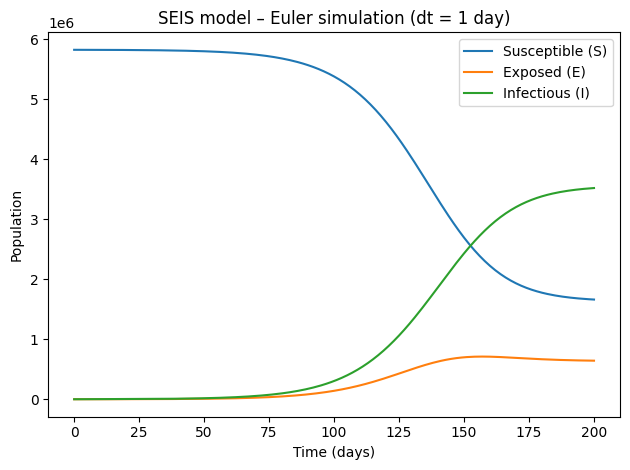

In [7]:

# --- Denmark COVID-19 scenario -------------------------------
beta    = 0.125        # from dataset
gamma   = 0.035       # from dataset
epsilon = 1/5.1            # 1 / 5.1-day incubation

S0 = 5_826_529             # susceptibles
E0 = 1_000                 # exposed
I0 = 500                   # infectious
days = 200                 # simulate ~ 5 months


t, S, E, I = simulate_seis(beta, gamma, epsilon, S0, E0, I0, days)

# Plot results
plt.figure()
plt.plot(t, S, label="Susceptible (S)")
plt.plot(t, E, label="Exposed (E)")
plt.plot(t, I, label="Infectious (I)")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("SEIS model – Euler simulation (dt = 1 day)")
plt.legend()
plt.tight_layout()
plt.show()

### Stochastic version